# Pass networks from Whoscored

Read the blogpost: https://www.dzialowski.eu/football-data-visualisations/

## Getting the match data from Whoscored

In [95]:
import json
import re
import pandas as pd
import numpy as np

In [2]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r', encoding='utf-8')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [3]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [180]:
match_html_path = './Manchester United 1-1 Burnley - Premier League 2023_2024 Live.html'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

In [195]:
players_df

,playerId,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId
0,260843,24,André Onana,GK,190,93,28,True,False,home,"{'totalSaves': {'0': 1.0, '26': 1.0, '34': 1.0...",NaN,NaN,NaN,NaN,NaN,NaN,32
1,331924,29,Aaron Wan-Bissaka,DR,183,72,26,True,False,home,"{'possession': {'0': 2.0, '5': 1.0, '13': 2.0,...",NaN,NaN,NaN,NaN,NaN,NaN,32
2,88526,18,Casemiro,DC,185,84,32,True,False,home,"{'possession': {'0': 2.0, '1': 3.0, '2': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,32
3,99487,5,Harry Maguire,DC,194,90,31,True,False,home,"{'possession': {'1': 1.0, '5': 3.0, '8': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,32
4,353418,20,Diogo Dalot,DL,183,76,25,True,False,home,"{'possession': {'4': 1.0, '9': 2.0, '11': 1.0,...",NaN,NaN,NaN,NaN,NaN,NaN,32
5,69344,14,Christian Eriksen,DMC,182,76,32,True,False,home,"{'possession': {'3': 1.0, '4': 1.0, '5': 1.0, ...",248144.0,"{'value': 2, 'displayName': 'SecondHalf'}",83.0,NaN,NaN,NaN,32
6,460260,37,Kobbie Mainoo,DMC,175,0,19,True,False,home,"{'possession': {'4': 1.0, '6': 1.0, '8': 1.0, ...",336915.0,"{'value': 2, 'displayName': 'SecondHalf'}",67.0,NaN,NaN,NaN,32
7,364315,21,Antony,AMR,174,63,24,True,False,home,"{'possession': {'0': 3.0, '13': 3.0, '18': 1.0...",NaN,NaN,NaN,NaN,NaN,NaN,32
8,123761,8,Bruno Fernandes,AMC,179,69,29,True,True,home,"{'possession': {'0': 2.0, '1': 2.0, '6': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,32
9,437022,17,Alejandro Garnacho,AML,180,80,19,True,False,home,"{'possession': {'1': 1.0, '6': 1.0, '7': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,32


## Preparing the data

### Passes dataframe

In [181]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType", "minute", "second", "period"]]

    return df_passes

In [182]:
passes_df = get_passes_df(events_dict)
#passes_df.head()
import pandas as pd

# Set options to display all rows and columns
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)



passes_df.head()

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,minute,second,period
2,2.678794e+09,50.1,49.7,26.4,40.7,184,371447.0,362426.0,Pass,Successful,0,1.0,"{'value': 1, 'displayName': 'FirstHalf'}"
3,2.678794e+09,28.0,40.4,75.2,77.9,184,362426.0,88526.0,Pass,Unsuccessful,0,4.0,"{'value': 1, 'displayName': 'FirstHalf'}"
4,2.678795e+09,20.2,17.6,26.0,14.9,32,88526.0,364315.0,Pass,Successful,0,8.0,"{'value': 1, 'displayName': 'FirstHalf'}"
5,2.678795e+09,26.0,14.9,20.9,15.1,32,364315.0,331924.0,Pass,Successful,0,9.0,"{'value': 1, 'displayName': 'FirstHalf'}"
7,2.678795e+09,21.3,15.1,53.0,39.4,32,331924.0,362826.0,Pass,Unsuccessful,0,11.0,"{'value': 1, 'displayName': 'FirstHalf'}"


In [183]:
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    
     # Filter to include only players who have made 2 or more passes between themselves
    passes_between_df = passes_between_df[passes_between_df['pass_count'] >= 4]
    
    # Extract top 5 partnerships and their pass count
    top_5_partnerships = passes_between_df.nlargest(5, 'pass_count')

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df, top_5_partnerships

In [184]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df, top_5_partnerships = get_passes_between_df(home_team_id, passes_df, players_df)

In [185]:
def print_top_5_partnerships(home_team_id, passes_df, players_df, teams_dict):
    home_passes_between_df, home_average_locs_and_count_df, top_5_partnerships = get_passes_between_df(home_team_id, passes_df, players_df)
    print("Top 5 Partnerships:")
    print(top_5_partnerships)

# Now call this function with the necessary arguments
print_top_5_partnerships(home_team_id, passes_df, players_df, teams_dict)

id1 = top_5_partnerships['pos_min'].iloc[0]
player_a_name = players_df[players_df['playerId'] == id1]['name'].iloc[0]

id2 = top_5_partnerships['pos_max'].iloc[0]
player_b_name = players_df[players_df['playerId'] == id2]['name'].iloc[0]

# Print the sentence
print(f"The most consistent partnership is between {player_a_name} and {player_b_name}.")



Top 5 Partnerships:
     pos_min   pos_max  pass_count
20   88526.0  260843.0          18
59  123761.0  364315.0          17
65  123761.0  437022.0          17
89  331924.0  364315.0          17
3    69344.0  123761.0          13
The most consistent partnership is between Casemiro and André Onana.


In [186]:
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df, top_5_partnerships = get_passes_between_df(away_team_id, passes_df, players_df)

In [187]:

# Now call this function with the necessary arguments
print_top_5_partnerships(away_team_id, passes_df, players_df, teams_dict)
id3 = top_5_partnerships['pos_min'].iloc[0]
player_c_name = players_df[players_df['playerId'] == id3]['name'].iloc[0]

id4 = top_5_partnerships['pos_max'].iloc[0]
player_d_name = players_df[players_df['playerId'] == id4]['name'].iloc[0]

# Print the sentence
print(f"The most consistent partnership is between {player_c_name} and {player_d_name}.")

Top 5 Partnerships:
     pos_min   pos_max  pass_count
99  362426.0  414233.0          33
49  273292.0  414233.0          23
94  362426.0  362826.0          18
40  273292.0  321020.0          15
71  321020.0  414233.0          15
The most consistent partnership is between Arijanet Muric and Maxime Esteve.


## Visualisation

In [188]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager

In [189]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    MIN_FONT_SIZE = 8
    
    # Calculate line width and marker size
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() * MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count'] / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)
    
    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency
    
    pitch = Pitch(pitch_type='opta', pitch_color='WHITE', line_color='#507293')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size,
                               color='RED', edgecolor='#507293', linewidth=1, alpha=1, ax=ax)
    
    # Calculate font size for player initials based on marker size
    max_marker_size = average_locs_and_count_df['marker_size'].max()
    font_size = 14 * (average_locs_and_count_df['marker_size'] / max_marker_size)
    
    # Apply minimum font size
    font_size = np.maximum(font_size, MIN_FONT_SIZE)
    
    # Annotate player initials
    for index, row in average_locs_and_count_df.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='BLACK', va='center',
                       ha='center', size=font_size[index], ax=ax)

    return pitch


In [190]:
'''# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()


# plot variables
main_color = '#FBFAF5'


# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14)

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color='BLACK', fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color='black', fontsize=14)
plt.savefig('output.png', bbox_inches='tight')
plt.show()'''

'# create plot\nfig, axes = plt.subplots(1, 2, figsize=(15, 8))\nplt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)\naxes = axes.flat\nplt.tight_layout()\n\n\n# plot variables\nmain_color = \'#FBFAF5\'\n\n\n# home team viz\npass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)\naxes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)\n\n# away team viz\npass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)\naxes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14)\n\nplt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=\'BLACK\', fontsize=42)\nsubtitle = "Passing networks and top combinations by volume of passes"\nplt.text(-10, 120, subtitle, horizontalalignment=\'center\', verticalalignment=\'center\', color=\'black\', fontsize=14)\nplt.savefig(\'output.png\', bbox_inches=\'tight\')\nplt.show()'

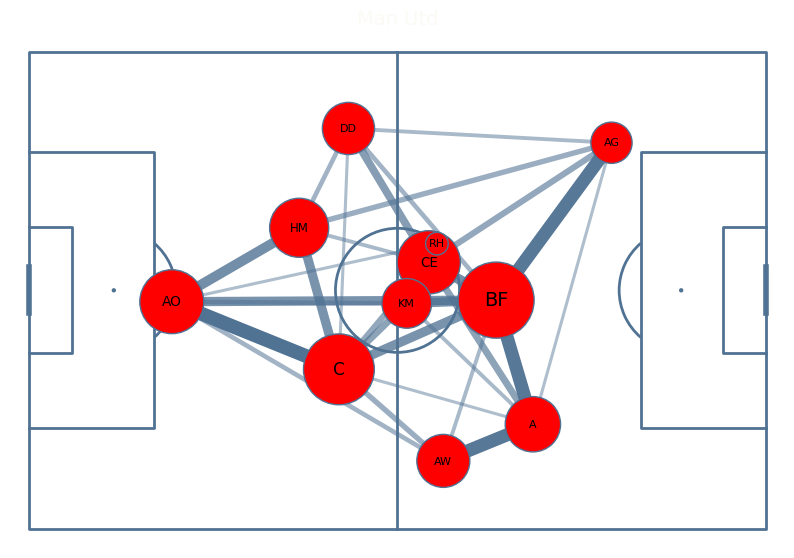

In [193]:
fig, ax = plt.subplots(figsize=(10, 8))  # Use a single subplot for the home team

# plot variables
main_color = '#FBFAF5'

# home team viz
pass_network_visualization(ax, home_passes_between_df, home_average_locs_and_count_df)

# Set title for the home team
ax.set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# Set suptitle and subtitle


# Save the image with the home team name as filename
plt.savefig(f"{teams_dict[home_team_id]}_vs_{teams_dict[away_team_id]}_{teams_dict[home_team_id]}_base_passing_network.png", bbox_inches='tight')

plt.show()


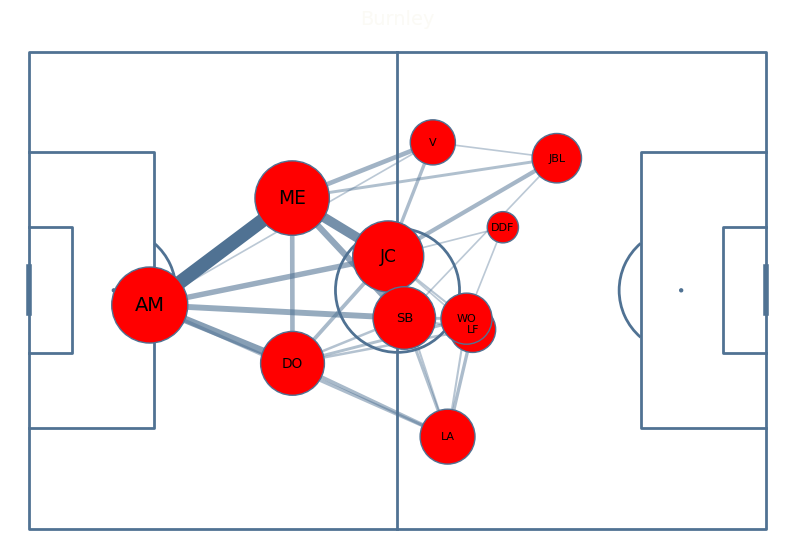

In [194]:
fig, ax = plt.subplots(figsize=(10, 8))  # Use a single subplot for the home team

# plot variables
main_color = '#FBFAF5'

# home team viz
pass_network_visualization(ax, away_passes_between_df, away_average_locs_and_count_df)

# Set title for the home team
ax.set_title(teams_dict[away_team_id], color=main_color, fontsize=14)

# Set suptitle and subtitle



# Save the image with the home team name as filename
plt.savefig(f"{teams_dict[home_team_id]}_vs_{teams_dict[away_team_id]}_{teams_dict[away_team_id]}_base_passing_network.png", bbox_inches='tight')
plt.show()
